In [14]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
from smstools.models import dftModel
from scipy.signal import savgol_filter

In [83]:
fs = 44100
length = 2048
max_peaks = 10 
num_peaks = np.random.randint(max_peaks)
frequency_bins = np.arange(length // 4)
distance = 10

In [84]:
def get_peak_positions(num_peaks, frequency_bins, distance):
    peak_positions = []

    for i in range(num_peaks):
        peak_position = np.random.choice(frequency_bins)
        peak_positions.append(peak_position)
        frequency_bins = np.concatenate([frequency_bins[frequency_bins < peak_position - distance], frequency_bins[frequency_bins > peak_position + distance]])

    peak_positions = np.array(peak_positions)

    return peak_positions

In [85]:
def generate_signal(peak_positions):
    signal = np.zeros(length)

    for i, peak_position in enumerate(peak_positions):
        peak_amplitude = np.random.uniform(0.05, 0.5)
        sinusoid = np.sin(2 * np.pi * peak_position / length * np.arange(length))
        signal += peak_amplitude * sinusoid

    return signal

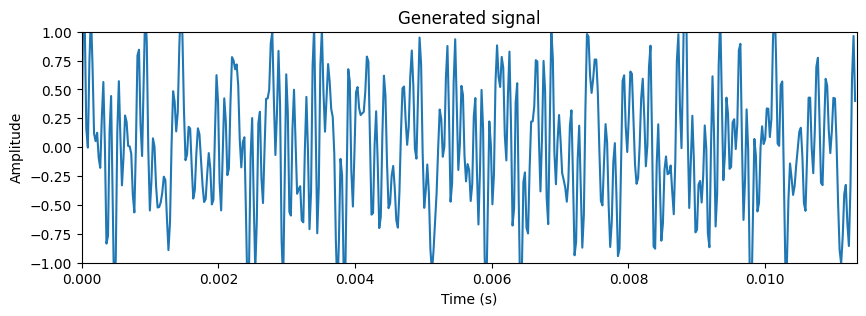

In [86]:
peak_positions = get_peak_positions(num_peaks, frequency_bins, distance)
signal = generate_signal(peak_positions)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(500) / fs, signal[:500])
plt.title('Generated signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.xlim(0, 500 / fs)
plt.ylim(-1, 1)
plt.show()

In [87]:
def lowpass(signal):
    signal = (signal[1:] + signal[:-1]) / 2
    signal = np.append(signal, 0)

    return signal

In [88]:
def add_noise(signal):
    noise = np.random.normal(0, 0.05, length)
    noise = (noise[1:] + noise[:-1]) / 2
    noise = np.append(noise, 0)

    signal += noise
    signal /= np.max(np.abs(signal))

    return signal

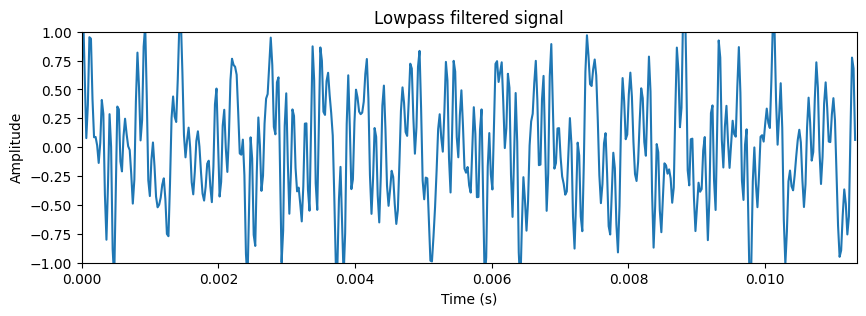

In [89]:
signal = lowpass(signal)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(500) / fs, signal[:500])
plt.title('Lowpass filtered signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.xlim(0, 500 / fs)
plt.ylim(-1, 1)
plt.show()

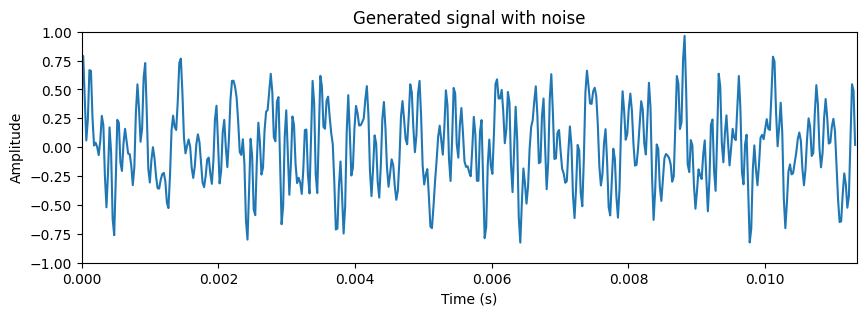

In [90]:
signal = add_noise(signal)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(500) / fs, signal[:500])
plt.title('Generated signal with noise')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.xlim(0, 500 / fs)
plt.ylim(-1, 1)
plt.show()

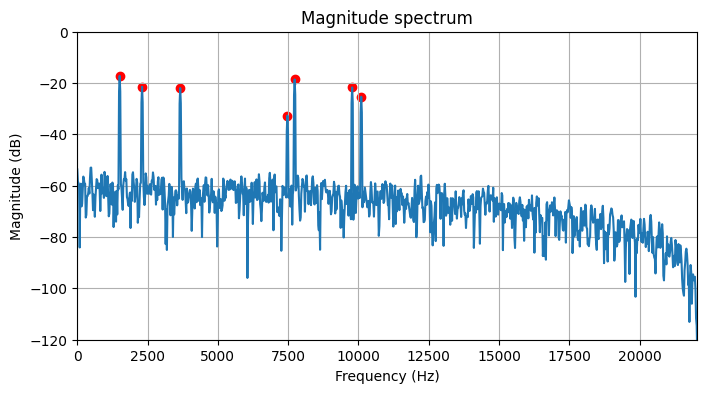

In [94]:
magnitude_spectrum, phase_spectrum = dftModel.dftAnal(signal, get_window('hann', length), length)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(magnitude_spectrum)) * fs / length, magnitude_spectrum)
plt.title('Magnitude spectrum')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.scatter(peak_positions * fs / length, magnitude_spectrum[peak_positions], color='red')
plt.xlim(0, fs / 2)
plt.ylim(-120, 0)
plt.grid()
plt.show()

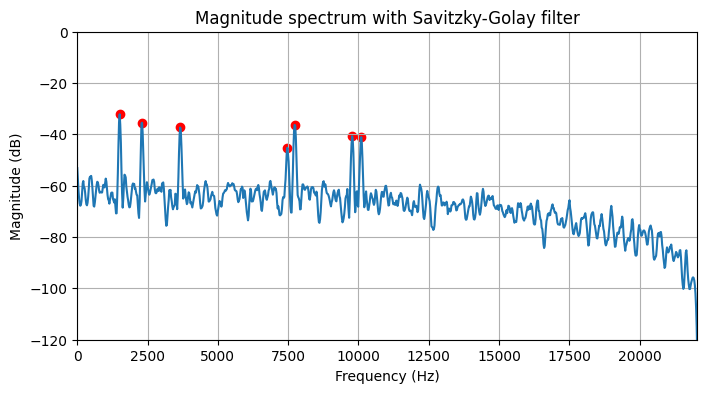

In [95]:
smoothed_spectrum = savgol_filter(magnitude_spectrum, window_length=15, polyorder=5)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(smoothed_spectrum)) * fs / length, smoothed_spectrum)
plt.title('Magnitude spectrum with Savitzky-Golay filter')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.scatter(peak_positions * fs / length, smoothed_spectrum[peak_positions], color='red')
plt.xlim(0, fs / 2)
plt.ylim(-120, 0)
plt.grid()
plt.show()

In [140]:
def create_dataset(num_samples):
    X = []
    Y = []

    for i in range(num_samples):
        num_peaks = np.random.randint(max_peaks)

        peak_positions = get_peak_positions(num_peaks, frequency_bins, distance)

        signal = generate_signal(peak_positions)
        signal = lowpass(signal)
        signal = add_noise(signal)

        magnitude_spectrum, phase_spectrum = dftModel.dftAnal(signal, get_window('hann', length), length)

        if np.random.rand() > 0.5:
            magnitude_spectrum = savgol_filter(magnitude_spectrum, window_length=15, polyorder=5)

        magnitude_spectrum = magnitude_spectrum * np.random.uniform(0.5, 2)
        magnitude_spectrum = magnitude_spectrum + np.random.randint(-50, 50)

        X.append(magnitude_spectrum)
        
        peaks = []

        for i in range(max_peaks):
            if i < num_peaks:
                peaks.append(1)
                peaks.append(peak_positions[i])
            else:
                peaks.append(0)
                peaks.append(0)
        
        Y.append(peaks)

    return X, Y

In [141]:
num_samples = 1000
X, Y = create_dataset(num_samples)

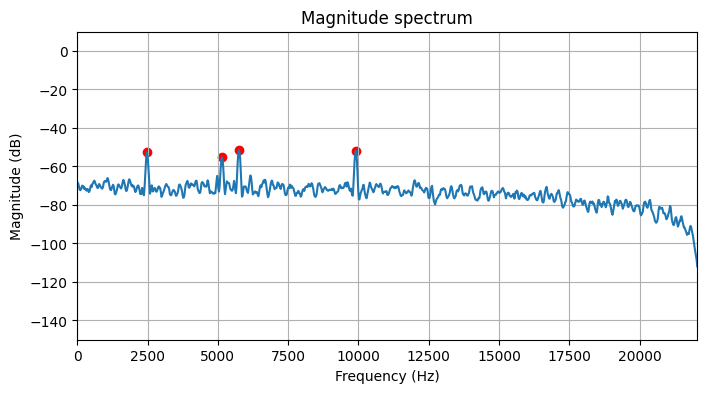

In [153]:
test_sample = np.random.randint(1000)

test_spectrum = X[test_sample]
test_peak_positions = np.array(Y[test_sample][1::2])
test_peak_positions = test_peak_positions[test_peak_positions != 0]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(test_spectrum)) * fs / length, test_spectrum)
plt.title('Magnitude spectrum')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.scatter(test_peak_positions * fs / length, test_spectrum[test_peak_positions], color='red')
plt.xlim(0, fs / 2)
plt.ylim(-150, 10)
plt.grid()
plt.show()